# Project Part 2 Solutions

## (a)

In [95]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]
file.files
Svc_0_PMF.shape[1]


array([2675.53744575, 2863.85791226, 3057.14728014, 3253.88149391,
       3452.04620117, 3649.7173123 , 3845.06100045, 4036.33370153,
       4221.88211425, 4400.14320005, 4569.64418319, 4729.00255065,
       4876.92605222, 5012.21270045, 5133.75077065, 5240.51880092,
       5331.58559212, 5406.11020788, 5463.63596652])

In [52]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [85]:
def SIR1(t, Z, N, betas, gamma,alpha):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -(betas*alpha)*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [172]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predited = np.zeros((nb_nodes))
R[0,10]

0.0

In [119]:
from random import seed
from random import random
def loss_func(alpha,node_index):
    initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))
    soln = solve_ivp(SIR1, (t[10], t[29]), initial_conditions, args=(N_node, beta_old, gamma,alpha), t_eval=t[10:29])

    S[node_index, :, :, 10:29] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:29] = soln.y[16:20]
    R[node_index, 10:29] = soln.y[20]
    L[node_index, 10:29] = Lc@soln.y[16:20]
    Lpredicted=L[node_index, 10:29]
    mse= mean_squared_error(Lpredicted,L_observed[node_index,10:29])
    #breakpoint()
    return mse


#seed(1)
#for x in range (10):
    #q=random()
    #a=loss_func(q,30)
    #print("MSE",a)
    #print("Alpha",q)



#for N_node, node_index in zip(N, range(nb_nodes)):
    #alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)


MSE 302293.3535004411
Alpha 0.13436424411240122
MSE 4338027.6511953045
Alpha 0.8474337369372327
MSE 1962040.3199373363
Alpha 0.763774618976614
MSE 240511.94259732316
Alpha 0.2550690257394217
MSE 118775.2346163661
Alpha 0.49543508709194095
MSE 123354.85458910096
Alpha 0.4494910647887381
MSE 526708.097909129
Alpha 0.651592972722763
MSE 2528231.7598376563
Alpha 0.7887233511355132
MSE 318309.9474323114
Alpha 0.0938595867742349
MSE 339931.16980751656
Alpha 0.02834747652200631


In [268]:
alpha_predicted[0]


0.22669982910156228

In [267]:
for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5,args=(node_index,N_node,),disp=False)
    #breakpoint()


In [273]:
q=alpha_predicted[2]
a=loss_func(q,2,N[2])
print("MSE",a)
print("Alpha",q)
sorted_alphas=alpha_predicted
sorted_alphas.sort()
print("Nodes ranked by how high theyre alphas is",sorted_alphas)

MSE 9120.570346529019
Alpha 0.1424926757812497
Nodes ranked by how high theyre alphas is [0.12352142 0.13822021 0.14249268 0.14443359 0.14606934 0.14807129
 0.15137939 0.15171814 0.1552803  0.16387329 0.16503143 0.16713867
 0.17045288 0.17644043 0.18051758 0.19622192 0.20018311 0.20029602
 0.20103149 0.20452881 0.20931396 0.20965576 0.21018066 0.22185059
 0.22246094 0.22650146 0.22669983 0.23173828 0.23728027 0.24645996
 0.24889221 0.25011292 0.25706787 0.26390381 0.26639404 0.26811523
 0.27178955 0.27543945 0.27561264 0.27568665 0.28189697 0.28358765
 0.28780823 0.2932373  0.29797363 0.3010498  0.30296936 0.31580811
 0.32045898 0.3225708  0.32358704 0.33059082 0.330896   0.33418884
 0.33525391 0.33642883 0.34067383 0.35007172 0.35155029 0.35754395
 0.3601532  0.36387939 0.37408447 0.3757782  0.38779907 0.39297028
 0.39484253 0.41170807 0.41690369 0.41756592 0.42473755 0.43126221
 0.43154907 0.44144897 0.44838867 0.45488892 0.46865234 0.49281006
 0.51626587 0.51790771 0.52313232 0.5358

In [242]:
from random import seed
from random import random
def loss_func(alpha,node_index,N):
    initial_conditions = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    soln = solve_ivp(SIR1, (t[10], t[29]), initial_conditions, args=(N, beta_old, gamma,alpha), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    Lpredicted=L[node_index, 10:30]
    mse= mean_squared_error(Lpredicted,L_observed[node_index,10:30])
    #breakpoint()
    return mse


## (b)

In [28]:
n=g_inv(A0[39])
nm=n+10000
m=g(nm)
An=g_inv(m)
print(m)

0.21361713586069922


In [276]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
    import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(sorted_alphas,A1, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")
    #plt.axis([0, 1, 0, 1])
def total_recovered_difference(alpha_afterNPI):
    
    
    
    return difference

### Policy #1

In [305]:
#i.
A1=[]
Newmoney=[]
for r in range(100):
    n=g_inv(sorted_alphas[r])
    nm=n+10000
    An=g(nm)
    m=g_inv(An)
    A1.append(An)
    Newmoney.append(m)


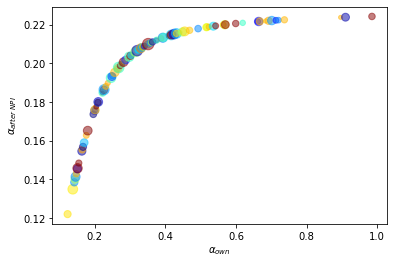

In [280]:
import matplotlib.pyplot as plt
scatter_plot(A1)

In [ ]:
#ii

### Policy #2

In [304]:
#i
N_percent=N/2714267.352274217
money=N_percent*1000000
A2=[]
Newmoney=[]
for r in range(100):
    n=g_inv(sorted_alphas[r])
    nm=n+money[r]
    An=g(nm)
    m=g_inv(An)
    A2.append(An)
    Newmoney.append(m)

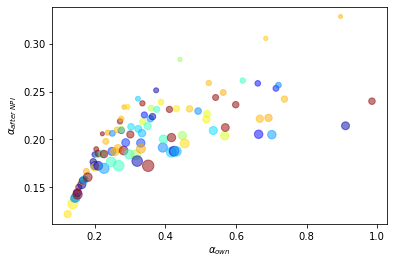

In [303]:
import matplotlib.pyplot as plt
scatter_plot(A2)

ii.

### Policy #3

i.

ii.

### Policy #4

i.

ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4